In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
paths = 'coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/'

In [3]:
register = {}

In [4]:
l2_snapshot = pd.DataFrame()

In [5]:
count = 0
day = pd.DataFrame()
i = 0
for x in os.listdir(paths):
    path = paths+x
    temp = pd.read_parquet(path)
    if count%24 == 0:
        day = pd.read_parquet(path)
    else:
        day = pd.concat([day,temp])
  
    i+=1
    count +=1

    if count%24 == 0:
        flag = not register
        day = day.dropna()
        print(day.shape)
        result = []
        for cols in day.columns:
            values = day[cols].to_numpy()
            mean = np.mean(values)
            std = np.std(values)
            result.append([cols,[mean,std]])
        register[count/24] = result
        if not flag:
            for l in range(200):
                prev_stat = register[(count/24)-1]
                col_name = prev_stat[l][0]
                col_mean = prev_stat[l][1][0]
                col_std = prev_stat[l][1][1]
                values = day[col_name].to_numpy()
                values = (values - col_mean)/col_std
                day[col_name] = values
            l2_snapshot = pd.concat([day,l2_snapshot])
        del day
  
    if i>240:
        break

(566480, 200)
(533024, 200)
(517431, 200)
(529814, 200)
(537967, 200)
(511850, 200)
(545960, 200)
(561058, 200)
(535563, 200)


In [6]:
def generate_features_labels(df,ask, bid,k=20, alpha = 10e-5):
    df_ = df.copy()
    df_['mid_price'] = (df_[ask].to_numpy()+df_[bid].to_numpy())/2
    df_['target'] = 1
    index = df_.columns.get_loc('mid_price')
    target_index = df_.columns.get_loc('target')
    shape = df_.shape[0]
    y = df_['target'].to_numpy()
    for i in tqdm(range(k,shape-k)):
        if i==k:
            m_b = np.mean(df_.iloc[(i-k):i, index].to_numpy())
            m_a = np.mean(df_.iloc[i+1:(i+k+1), index].to_numpy())
            val = df_.iloc[i-k,index]
            valB = df_.iloc[i+1, index]
        else:
            curr_val = df_.iloc[i-1,index]
            curr_valB = df_.iloc[i+k, index]
            m_b = (m_b*k+(curr_val)-(val))/k
            m_a = (m_a*k+(curr_valB - valB))/k
            val = df_.iloc[(i-k),index]
            valB = df_.iloc[(i+1), index]

        if (m_b > m_a*(1+alpha)):
            y[i] = 2
        if (m_b < m_a*(1-alpha)):
            y[i] = 0

    y = y[k:shape-k]
    X = df.iloc[k:shape-k,:].to_numpy()
    return X,y

In [7]:
# GridSearch
min_ = float('inf')
minI = 0
for i in np.logspace(0,-8,10, endpoint = True):
    X,y = generate_features_labels(l2_snapshot, ask='a1', bid = 'b1', alpha=i)
    y_ = pd.Series(y)
    temp = y_.value_counts()
    a,b,c = temp[0], temp[1], temp[2]
    sum_ = a+b+c
    l2 = ((1/3-(a/sum_))*100)**2 + ((1/3-(b/sum_))*100)**2 + ((1/3-(c/sum_))*100)**2
    if l2 < min_:
        min_ = l2
        minI = i
    del X,y,temp

100%|██████████| 4272627/4272627 [03:06<00:00, 22967.97it/s]


In [ ]:
# GridSearch
min_ = float('inf')
minI = 0
for i in np.logspace(0,-8,10, endpoint = True):
    X,y = generate_features_labels(l2_snapshot, ask='a1', bid = 'b1', alpha=i)
    y_ = pd.Series(y)
    temp = y_.value_counts()
    a,b,c = temp[0], temp[1], temp[2]
    sum_ = a+b+c
    l2 = ((1/3-(a/sum_))*100)**2 + ((1/3-(b/sum_))*100)**2 + ((1/3-(c/sum_))*100)**2
    if l2 < min_:
        min_ = l2
        minI = i
    del X,y,temp

In [8]:
print(minI, min_)

7.742636826811277e-08 0.034751453285264196


In [ ]:
X,y = generate_features_labels(l2_snapshot, ask='a1', bid = 'b1', alpha=minI)

 53%|█████▎    | 2282334/4272627 [01:41<01:27, 22744.08it/s]

In [ ]:
X = X.astype('float16')
y = y.astype('int')

In [ ]:
X.nbytes/(1024*1024*1024)

In [ ]:
sns.countplot(x = y)

In [11]:
T = 100
D = 200
N = len(X) - T

In [12]:
trainPart = 3176046

In [13]:
X_train = np.zeros((trainPart, T, D), dtype = 'float16')
y_train = np.zeros(trainPart, dtype = 'float16')

#Preparing the time series data using timestep of 100 and no of features = 200
for t in range(trainPart):
    X_train[t, :, :] = X[t:t+T]
    y_train[t] = y[t+T] 


In [14]:
print('X_train - Before: {} GB'.format(X_train.nbytes/1024**3), X_train.dtype)

X_train - Before: 118.31693351268768 GB float16


In [15]:
print('y_train - Before: {} GB'.format(y_train.nbytes/1024**3), y_train.dtype)

y_train - Before: 0.005915846675634384 GB float16


In [16]:
X_test = np.zeros((N - trainPart, T, D), dtype='float16')
y_test = np.zeros(N - trainPart, dtype='float16')

#Preparing the time series data using timestep of 100 and no of features = 200
for k in range(N - trainPart):
    t = k + trainPart
    X_test[k, :, :] = X[t:t+T]
    y_test[k] = y[t+T]

print('X_test - Before: {} GB'.format(X_test.nbytes/1024**3), X_test.dtype)
print('y_test - Before: {} GB'.format(y_test.nbytes/1024**3), y_test.dtype)

X_test - Before: 40.84710031747818 GB float16
y_test - Before: 0.002042355015873909 GB float16


In [17]:
del X, y, l2_snapshot

In [18]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [19]:
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [20]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [21]:
i = Input(shape=X_train[0].shape)
print(i)
x = Conv2D(16, (4,D), activation=LeakyReLU(alpha=0.01))(i)
print(x.shape)
x = tf.keras.layers.Reshape(target_shape=(T-3,16))(x)
print(x.shape)
x = Conv1D(16, 4, activation=LeakyReLU(alpha=0.01))(x)
x = MaxPooling1D(2)(x)
#x = Conv1D(32, 3, activation=LeakyReLU(alpha=0.01))(x)
x = Conv1D(32, 3, activation=LeakyReLU(alpha=0.01))(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = Dense(32, activation=LeakyReLU(alpha=0.01))(x)
x = Dense(32, activation=LeakyReLU(alpha=0.01))(x)
x = Dense(3, activation='softmax')(x)

model = Model(i,x)

Tensor("input_1:0", shape=(None, 100, 200, 1), dtype=float32)
(None, 97, 1, 16)
(None, 97, 16)


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 200, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 97, 1, 16)         12816     
_________________________________________________________________
reshape (Reshape)            (None, 97, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 16)            1040      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 47, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 45, 32)            1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 32)            0     

In [23]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
EPOCHS = 4
BATCH_SIZE = 32
r = model.fit(
  X_train, y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test, y_test),
)

Train on 3176046 samples, validate on 1096481 samples
Epoch 1/4
3176046/3176046 [==============================] - 455s 143us/sample - loss: 0.5220 - accuracy: 0.7843 - val_loss: 0.4889 - val_accuracy: 0.7996
Epoch 2/4
3176046/3176046 [==============================] - 433s 136us/sample - loss: 0.4824 - accuracy: 0.8066 - val_loss: 0.4732 - val_accuracy: 0.8068
Epoch 3/4
3176046/3176046 [==============================] - 429s 135us/sample - loss: 0.4738 - accuracy: 0.8111 - val_loss: 0.4746 - val_accuracy: 0.8096
Epoch 4/4
3176046/3176046 [==============================] - 427s 134us/sample - loss: 0.4733 - accuracy: 0.8142 - val_loss: 0.4793 - val_accuracy: 0.8055


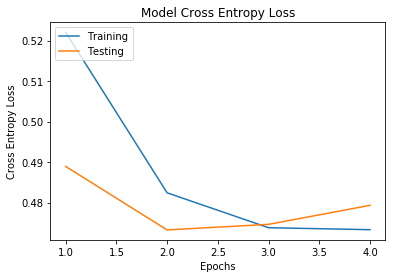

In [25]:
sns.lineplot(x=range(1,EPOCHS+1),y=r.history['loss'])
sns.lineplot(x=range(1,EPOCHS+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'], loc='upper left')

In [ ]:
y_pred = model.predict(X_test).argmax(axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=[0,1,2], yticklabels=[0,1,2], cmap='Blues')
ax.set_ylim(3.0, 0)
plt.show()